# Gaussian Mixture Model
this notebook is adapted from python data science handbook

In [1]:
%matplotlib inline
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set(style='whitegrid')
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse

In [2]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

Text(0.5, 1.0, 'two half circles')

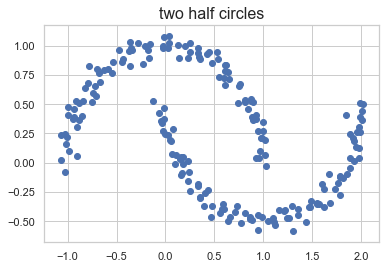

In [3]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);
plt.title('two half circles', fontsize=16)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

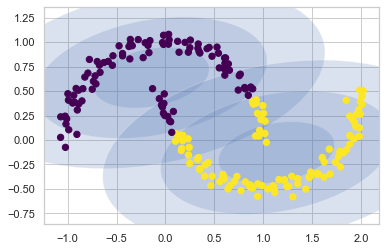

In [4]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

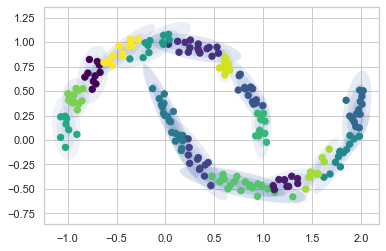

In [5]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=True)

This is not clustering taks, so we can ignore the lables (color)

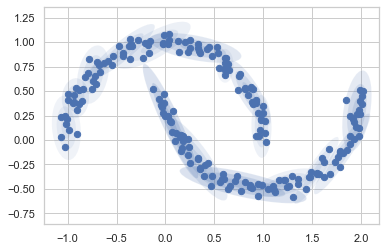

In [6]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

From the above figure, we can say that the GMM covers the data distribution

GMM is a generative model because we can generate samples from it.

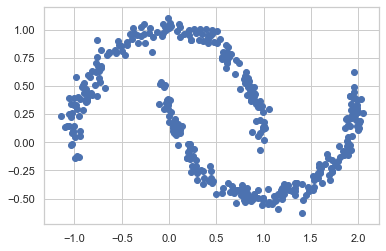

In [7]:
Xnew,_ = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

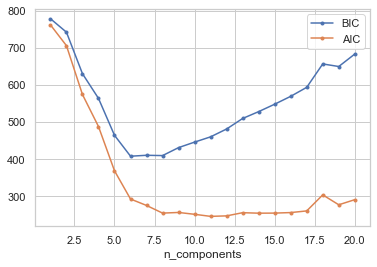

In [8]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], '.-', label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], '.-', label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Example: GMM for Generating New Data

Once we have a GMM built from a dataset, we can use it to generate new data

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

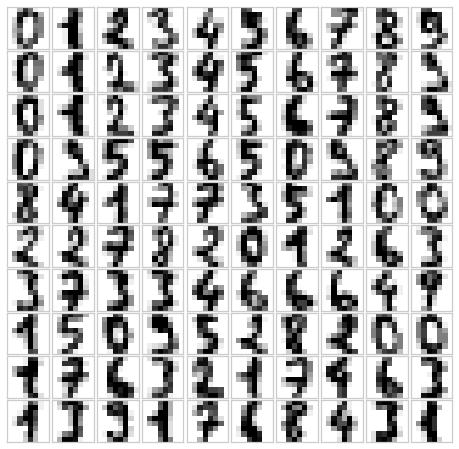

In [9]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [10]:
# the shape of the dataset
digits.data.shape

(1797, 64)

We have nearly 1,800 digit images. Each image has 64 pixels. (a data point/vector has 64 elements) <br>
So, we need a 64-dim GMM to model the data distribution <br>
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA to transform the data, after the transformation, a data point only has 41 elements.

In [11]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

Now, we fit GMM to the transformed data <br>
We will try GMMs with different number of components <br>
We will select the best one based on AIC

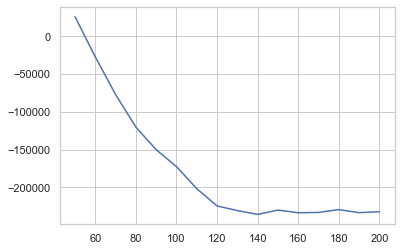

In [13]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It appears that around 120 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [14]:
gmm = GMM(n_components=120, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points from  the gmm <br>
The new data points are in the 41-dimensional projected space

In [15]:
data_new, _ = gmm.sample(100)
data_new.shape

(100, 41)

Finally, we can use transform the data back to the 64-dimensional space

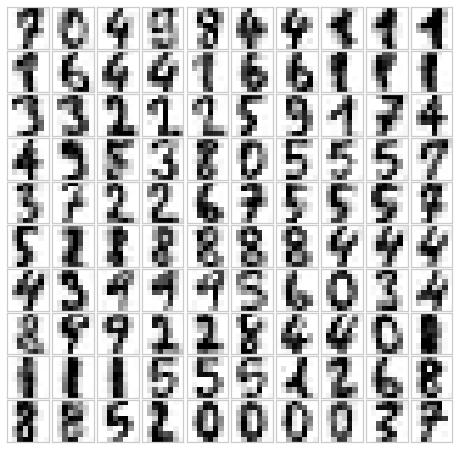

In [16]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model. <br>
There are other generative models, such as generative adversarial networks